In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd

In [21]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func
from dateutil.relativedelta import relativedelta

In [23]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [25]:
# We can view all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [26]:
# Get a list of column names and types for measurements table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [27]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Earliest Date
earliest_date=session.query(Measurement.date).order_by(Measurement.date).first()  
earliest_date

('2010-01-01')

In [30]:
# Latest date
latest_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first().date 
latest_date

'2017-08-23'

In [31]:
# Date 12 months from the latest date
last_twelve_months = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
last_twelve_months

datetime.datetime(2016, 8, 23, 0, 0)

In [32]:
# Query for last 12 months of precipitation
last_12_months_precipitation = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2016-08-24').filter(Measurement.date <= '2017-08-23').group_by(Measurement.date).all()
last_12_months_precipitation

[('2016-08-24', 1.45),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.01),
 ('2016-08-27', None),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.05),
 ('2016-08-31', 2.46),
 ('2016-09-01', 0.01),
 ('2016-09-02', 0.03),
 ('2016-09-03', 1.0),
 ('2016-09-04', 0.44),
 ('2016-09-05', 0.18),
 ('2016-09-06', 1.0),
 ('2016-09-07', 1.35),
 ('2016-09-08', 0.15),
 ('2016-09-09', 0.35),
 ('2016-09-10', 1.16),
 ('2016-09-11', 0.6),
 ('2016-09-12', 1.04),
 ('2016-09-13', 1.2),
 ('2016-09-14', 6.7),
 ('2016-09-15', 3.35),
 ('2016-09-16', 0.61),
 ('2016-09-17', 0.23),
 ('2016-09-18', 0.42),
 ('2016-09-19', 0.25),
 ('2016-09-20', 0.43),
 ('2016-09-21', 1.02),
 ('2016-09-22', 0.75),
 ('2016-09-23', 0.33),
 ('2016-09-24', 0.27),
 ('2016-09-25', 0.04),
 ('2016-09-26', 1.02),
 ('2016-09-27', 1.0),
 ('2016-09-28', 0.05),
 ('2016-09-29', 1.49),
 ('2016-09-30', 0.38),
 ('2016-10-01', 1.02),
 ('2016-10-02', 0.61),
 ('2016-10-03', 0.46),
 ('2016-10-04', 3.46),
 ('2016-10-05', 0.81),
 ('2016-10-06', 0.

In [34]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_df = pd.DataFrame(last_12_months_precipitation, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date',inplace=True)
precipitation_df.sort_values(by=['Date'])
precipitation_df.head()

,Precipitation
Date,
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,NaN
2016-08-28,2.07


In [35]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,344.000000
mean,0.431308
std,0.705240
min,0.000000
25%,0.010000
50%,0.140000
75%,0.565000
max,6.700000


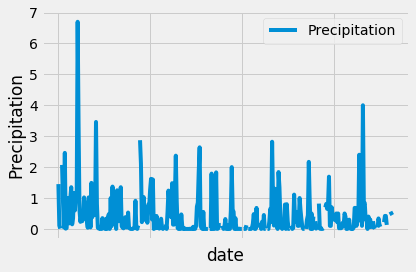

In [36]:
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
precipitation_df.plot(x_compat=True)
# Rotate the xticks for the dates
plt.ylabel("Precipitation")
plt.xlabel("date")
plt.xticks(rotation='45')
plt.tight_layout()
plt.show()

In [37]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
station_count

9

In [38]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
s_results = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
s_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Using the station id from the previous query;
# calculate the lowest temperature recorded, highest temperature recorded, and average temperature for the most active station.
best_station = s_results[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [166]:
# Choose the station with the highest number of temperature observations.
t_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == best_station).\
                filter(Measurement.date >= '2016-08-24').all()
tobs_df = pd.DataFrame(t_results)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


<function matplotlib.pyplot.show(*args, **kw)>

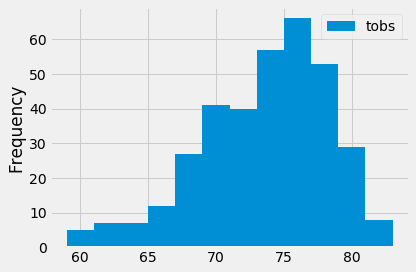

In [168]:
# plot the results as a histogram
station_high_temp_obs = pd.DataFrame(results, columns=['tobs'])
station_high_temp_obs.plot.hist(bins=12)
plt.tight_layout()
plt.show

In [172]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [180]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2019-05-12','2019-05-19'))

[(None, None, None)]


In [189]:
#There is no information for my dates above(used Yr 2017 for the same dates)
trip_results = calc_temps('2017-05-12','2017-05-19')
trip_results

[(68.0, 74.70454545454545, 79.0)]

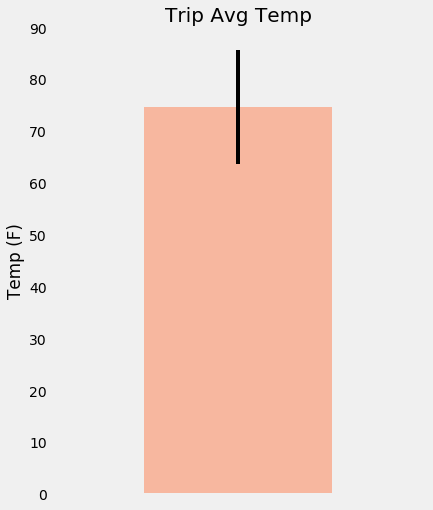

In [192]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("Resources/TripTempSummary.png")
plt.show()

In [193]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation.
last_12_months= session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2016-05-12').filter(Measurement.date <= '2016-05-19').group_by(Measurement.date).all()
last_12_months
start_date = '2016-05-12'
end_date = '2016-05-19'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.4), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.56), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.44), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.36), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.32999999999999996), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02)]


## Optional Challenge Assignment

In [195]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [196]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
Start_date= '2017-05-12'
End_date='2017-05-19'
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(Start_date, End_date, freq='D')
# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(65.0, 73.13793103448276, 79.0),
 (67.0, 73.14285714285714, 79.0),
 (63.0, 73.89285714285714, 80.0),
 (63.0, 73.69090909090909, 79.0),
 (68.0, 74.37931034482759, 80.0),
 (68.0, 74.45, 79.0),
 (68.0, 74.10714285714286, 82.0),
 (65.0, 73.80701754385964, 79.0)]

In [199]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
normals_df['date'] = trip_dates
normals_df.set_index(['date'],inplace=True)
normals_df

,tmin,tavg,tmax
date,,,
2017-05-12,65.0,73.137931,79.0
2017-05-13,67.0,73.142857,79.0
2017-05-14,63.0,73.892857,80.0
2017-05-15,63.0,73.690909,79.0
2017-05-16,68.0,74.379310,80.0
2017-05-17,68.0,74.450000,79.0
2017-05-18,68.0,74.107143,82.0
2017-05-19,65.0,73.807018,79.0


# Plot the daily normals as an area plot with `stacked=False`


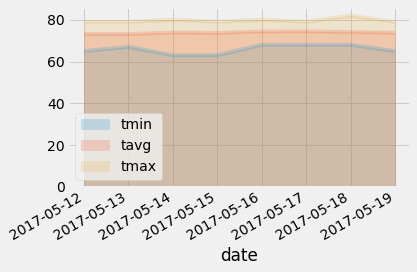

In [200]:
normals_df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()